# A new Jazz Club in Paris - Capstone Project

## Table of Contents

1. [Data acquisition and Cleaning](#data_acq_cleaning)
    1. [Retrieve data from Wikipedia using web scraping](#wikipedia)
    1. [Display data by "arrondissements"](#d_arr)
    1. [Display data by "quartiers"](#d_quartier)

1. [Exploratory Data Analysis](#expl_da)
    1. [Initialize Foursquare API](#foursquare)
    1. [Data exploration of "quartier Sorbonne"](#da_qs)
    1. [Data exploration of Paris' quartiers](#da_paris)
    1. [Study of Top 10 Quartier](#da_top)

1. [Explore and cluster neighborhoods](#explore_cluster)
    1. [Explore neighborhoods](#exp_n)
    1. [Data preparation](#data_prep)
    1. [Neighborhoods Clustering](#clustering)
    1. [Cluster Analysis](#cluster_analysis)
    1. [Superposition of clusters and number of music venues](#superposition)

1. [A new Jazz Club in Paris](#new_jazz_club)

1. [Conclusion and Results](#conclusion_results)

<hr>

In [184]:
import pandas as pd
import numpy as np
import folium
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

## Data acquisition and Cleaning <a id="data_acq_cleaning"></a>

### Retrieve data from Wikipedia using web scraping <a id="wikipedia"></a>

Let's first scrape our wikipedia page using BeautifulSoup.

In [190]:
postal_code_url = requests.get('https://en.wikipedia.org/wiki/Quarters_of_Paris').text
soup = BeautifulSoup(postal_code_url,'lxml')

In [191]:
My_table = soup.find('table',{'class':'wikitable centre'})

#Put into pandas dataframe
df = pd.read_html(str(My_table))[0]

#Drop unecessary data such as area, and map (we keep area(hectares) for testing purpose)
df.drop(['Population in1999[3]','Map'], axis=1, inplace=True)

#Rename columns to have something nice
df.rename(columns={"Arrondissement(Districts)": "Arrondissement", "Quartiers(Quarters)": "Quartiers", "Quartiers(Quarters).1": "Quartier Name"}, inplace=True)
df.head(10)

,Arrondissement,Quartiers,Quartier Name,Area(hectares)[3]
0,"1st arrondissement(Called ""du Louvre"")",1st,Saint-Germain-l'Auxerrois,86.9
1,"1st arrondissement(Called ""du Louvre"")",2nd,Les Halles,41.2
2,"1st arrondissement(Called ""du Louvre"")",3rd,Palais-Royal,27.4
3,"1st arrondissement(Called ""du Louvre"")",4th,Place-Vendôme,26.9
4,"2nd arrondissement(Called ""de la Bourse"")",5th,Gaillon,18.8
5,"2nd arrondissement(Called ""de la Bourse"")",6th,Vivienne,24.4
6,"2nd arrondissement(Called ""de la Bourse"")",7th,Mail,27.8
7,"2nd arrondissement(Called ""de la Bourse"")",8th,Bonne-Nouvelle,28.2
8,"3rd arrondissement(Called ""du Temple"")",9th,Arts-et-Métiers,31.8
9,"3rd arrondissement(Called ""du Temple"")",10th,Enfants-Rouges,27.2


Our data set is missing postal code in order to identify each neighborhood in geojson file. We add manually the column using the fact that : 

**postal_code_xx = '7510' + 'xx' (xx = arrondissement number)**

In [192]:
#let's keep non duplicate values of arrondissement
df_arrondissements = df[['Arrondissement']].drop_duplicates(ignore_index=True)
df_arrondissements

postal_code=[]
arrondissement_nb=[]
#build postal code
for index, row in df_arrondissements.iterrows():
    if (index+1) < 10:
        postal_code.append('7510'+str(index+1))
    else:
        postal_code.append('751'+str(index+1))
    arrondissement_nb.append(index+1)

#create a dataframe with postal code and arrondissement number
df_arrondissements['Code']=postal_code
df_arrondissements['Arrondissement_nb']=arrondissement_nb

#merge the dataframe in the previous one
df = pd.merge(df_arrondissements,df)

### Display data by "arrondissements" <a id="d_arr"></a>

In [196]:
#let's load geojson file
paris_arrondissements_geo = 'arrondissements.geojson'

#paris coordinates
paris_longitude = 2.3488
paris_latitude = 48.8534

In [197]:
paris_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=paris_arrondissements_geo,
    data=df,
    columns=['Code', 'Area(hectares)[3]'],
    key_on='feature.properties.code',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Neighborhoods paris').add_to(paris_map)

# display map
paris_map

From this point, we can represent whatever data by arrondissement. We need now to collect latitude and longitude of the quartiers (neighborhoods) in order to display them on the map. 

In [198]:
latitude = []
longitude = []

geolocator = Nominatim(user_agent="fr_explorer")

for index, row in df.iterrows():
    location = geolocator.geocode(row[4]+', Paris')
    print(row[4])
    latitude.append(location.latitude)
    longitude.append(location.longitude)
    
# we put the result of the loop in new columns 'latitude' and 'longitude'
df['Latitude'] = latitude
df['Longitude'] = longitude

Saint-Germain-l'Auxerrois
Les Halles
Palais-Royal
Place-Vendôme
Gaillon
Vivienne
Mail
Bonne-Nouvelle
Arts-et-Métiers
Enfants-Rouges
Archives
Sainte-Avoye
Saint-Merri
Saint-Gervais
Arsenal
Notre-Dame
Quartier Saint-Victor
Jardin-des-Plantes
Val-de-Grâce
Sorbonne
Monnaie
Odéon
Notre-Dame-des-Champs
Saint-Germain-des-Prés
Saint-Thomas-d'Aquin
Les Invalides
École-Militaire
Gros-Caillou
Champs-Élysées
Faubourg-du-Roule
La Madeleine
Europe
Saint-Georges
Chaussée-d'Antin
Faubourg-Montmartre
Rochechouart
Saint-Vincent-de-Paul
Porte-Saint-Denis
Porte-Saint-Martin
Hôpital-Saint-Louis
Folie-Méricourt
Saint-Ambroise
La Roquette
Sainte-Marguerite
Bel-Air
Picpus
Bercy
Quinze-Vingts
Salpêtrière
La Gare
Maison-Blanche
Croulebarbe
Montparnasse
Parc Montsouris
Petit-Montrouge
Plaisance
Saint-Lambert
Necker
Grenelle
Javel
Auteuil
La Muette
Porte-Dauphine
Chaillot
Les Ternes
Plaine Monceau
Batignolles
Épinettes
Grandes-Carrières
Clignancourt
Goutte-d'Or
La Chapelle
La Villette
Pont-de-Flandre
Amérique
Com

In [199]:
#Display Arrondissements limits and Quartiers' name
for lat, lng, label in zip(df.Latitude, df.Longitude, df['Quartier Name']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        popup=label,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(paris_map)

# display map
paris_map

The level of granularity with "arrondissement" doen't seem to be enough. It would be more interesting to split data into quartiers (neighborhoods).

### Display data by "quartiers" <a id="d_quartier"></a>

In the geojson file, we can see there is a parameter called "c_quinsee". It represents an INSEE ID, allowing to identify each quartier.

I so decided to add to my dataframe a new column with this INSEE identification, consisting of : 

**'75101' + 'xx' (xx: ID of the quartier)**

In [201]:
code="75101"
i=0
j=0
resp=[]
v=[]

for index, row in df.iterrows():
    if code == row[1]:
        i=i+1;
        j=j+1;
    else:
        i=1
        j=1
        code=row[1]
    resp.append(code+"0"+str(i))
    
df['INSEE_ID'] = resp
df['INSEE_ID']=df['INSEE_ID'].astype(int)
df.head(5)

,Arrondissement,Code,Arrondissement_nb,Quartiers,Quartier Name,Area(hectares)[3],Latitude,Longitude,INSEE_ID
0,"1st arrondissement(Called ""du Louvre"")",75101,1,1st,Saint-Germain-l'Auxerrois,86.9,48.860211,2.336299,7510101
1,"1st arrondissement(Called ""du Louvre"")",75101,1,2nd,Les Halles,41.2,48.862466,2.346009,7510102
2,"1st arrondissement(Called ""du Louvre"")",75101,1,3rd,Palais-Royal,27.4,48.863585,2.336204,7510103
3,"1st arrondissement(Called ""du Louvre"")",75101,1,4th,Place-Vendôme,26.9,48.867463,2.329428,7510104
4,"2nd arrondissement(Called ""de la Bourse"")",75102,2,5th,Gaillon,18.8,48.869135,2.332909,7510201


In [204]:
my_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12, 
                    tiles='Stamen Toner')

folium.Choropleth(
    geo_data=paris_quartier_geo,
    data=df,
    columns=['INSEE_ID', 'Area(hectares)[3]'],
    key_on='feature.properties.c_quinsee',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Neighborhoods paris').add_to(my_map)

# loop through the quartiers'name and add each to the map
for lat, lng, name, arrondissement_nb in zip(df.Latitude, df.Longitude, df['Quartier Name'], df.Arrondissement_nb):
    folium.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color='blue',
        fill=True,
        popup=(name+' ('+str(arrondissement_nb)+'e'+')'),
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(my_map)

# display map
my_map

## Exploratory Data Analysis <a id="expl_da"></a>

### Initialize Foursquare API <a id="foursquare"></a>

In [205]:
CLIENT_ID = '1UG5N54OGSL3W13G0KBFGEPUUOIS4UD5K11UD1EK5CHGBDSJ' # your Foursquare ID
CLIENT_SECRET = 'NN3CFNBEDB0NUFRW2VIWW3WFVTUOL1IU4E5B4YTC2U1KDTON' # your Foursquare Secret
VERSION = '20200714' # Foursquare API version

### Data exploration of "quartier Sorbonne" <a id="da_qs"></a>

In [206]:
# Get the neighborhood's latitude and longitude values
neighborhood_latitude = df.loc[19, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[19, 'Longitude'] # neighborhood longitude value
neighborhood_name = df.loc[19, 'Quartier Name'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Sorbonne are 48.84912335, 2.3453251499821075.


Let's now create a foursquare request to retrieve the first 100 music venues categories in a 500m radius.

In [207]:
#First, let's create the GET request URL :
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d1e5931735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d1e5931735&client_id=1UG5N54OGSL3W13G0KBFGEPUUOIS4UD5K11UD1EK5CHGBDSJ&client_secret=NN3CFNBEDB0NUFRW2VIWW3WFVTUOL1IU4E5B4YTC2U1KDTON&v=20200714&ll=48.84912335,2.3453251499821075&radius=500&limit=100'

Let's send the GET request and examine the resutls :

In [209]:
results = requests.get(url).json()
venues = results['response']['venues']
venues

[{'id': '4adcda05f964a520523221e3',
  'name': 'Le Piano Vache',
  'location': {'address': '8 rue Laplace',
   'lat': 48.847266816912025,
   'lng': 2.347707272470676,
   'labeledLatLngs': [{'label': 'display',
     'lat': 48.847266816912025,
     'lng': 2.347707272470676}],
   'distance': 270,
   'postalCode': '75005',
   'cc': 'FR',
   'city': 'Paris',
   'state': 'Île-de-France',
   'country': 'France',
   'formattedAddress': ['8 rue Laplace', '75005 Paris', 'France']},
  'categories': [{'id': '4bf58dd8d48988d11b941735',
    'name': 'Pub',
    'pluralName': 'Pubs',
    'shortName': 'Pub',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1595805761',
  'hasPerk': False},
 {'id': '4b4afc11f964a520899026e3',
  'name': 'Le Caveau des Oubliettes',
  'location': {'address': '52 rue Galande',
   'lat': 48.85200681507648,
   'lng': 2.3467357456684113,
   'labeledLatLngs': [{'label': 'display',
   

We build a function that extracts the category of the venue :

In [210]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [211]:
# flatten JSON
nearby_venues = pd.json_normalize(venues)

filter_column = ['name','categories','location.lat','location.lng','location.formattedAddress']
nearby_venues=nearby_venues[filter_column]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

#drop 'categories column'
nearby_venues.drop(['categories'], axis=1, inplace=True)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,lat,lng,formattedAddress,categories
0,Le Piano Vache,48.847267,2.347707,"[8 rue Laplace, 75005 Paris, France]",Pub
1,Le Caveau des Oubliettes,48.852007,2.346736,"[52 rue Galande, 75005 Paris, France]",Jazz Club
2,Caveau de la Huchette,48.852785,2.346305,"[5 rue de la Huchette, 75005 Paris, France]",Jazz Club
3,Aux Trois Mailletz,48.852177,2.346609,"[56 rue Galande, 75005 Paris, France]",Piano Bar
4,Le Petit Journal Saint Michel,48.846467,2.340402,"[71 boulevard Saint-Michel, 75005 Paris, France]",Jazz Club
5,Le Petit Jornal,48.845281,2.340555,"[Boulevard Saint Michel, Paris, France]",Jazz Club
6,Boub's,48.850926,2.339206,[France],Jazz Club
7,Piano Bar,48.852967,2.345922,"[14 rue de la Huchette, 75005 Paris, France]",Piano Bar
8,studio purple,48.847867,2.351259,[France],Music Venue


### Data exploration of Paris' quartiers <a id="da_paris"></a>

 Let's create a function to repeat the same process to all the neighborhoods in Paris

In [213]:
def getNearbyMusicVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d1e5931735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request        
        results = requests.get(url).json()['response']['venues']        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['categories'][0]['name'],
            v['location']['lat'], 
            v['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Quartier Name', 
                  'Quartier Latitude', 
                  'Quartier Longitude', 
                  'Venue', 
                  'Venue Category',
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

In [214]:
df.head()

,Arrondissement,Code,Arrondissement_nb,Quartiers,Quartier Name,Area(hectares)[3],Latitude,Longitude,INSEE_ID
0,"1st arrondissement(Called ""du Louvre"")",75101,1,1st,Saint-Germain-l'Auxerrois,86.9,48.860211,2.336299,7510101
1,"1st arrondissement(Called ""du Louvre"")",75101,1,2nd,Les Halles,41.2,48.862466,2.346009,7510102
2,"1st arrondissement(Called ""du Louvre"")",75101,1,3rd,Palais-Royal,27.4,48.863585,2.336204,7510103
3,"1st arrondissement(Called ""du Louvre"")",75101,1,4th,Place-Vendôme,26.9,48.867463,2.329428,7510104
4,"2nd arrondissement(Called ""de la Bourse"")",75102,2,5th,Gaillon,18.8,48.869135,2.332909,7510201


In [215]:
paris_music_venues = getNearbyMusicVenues(names=df['Quartier Name'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Saint-Germain-l'Auxerrois
Les Halles
Palais-Royal
Place-Vendôme
Gaillon
Vivienne
Mail
Bonne-Nouvelle
Arts-et-Métiers
Enfants-Rouges
Archives
Sainte-Avoye
Saint-Merri
Saint-Gervais
Arsenal
Notre-Dame
Quartier Saint-Victor
Jardin-des-Plantes
Val-de-Grâce
Sorbonne
Monnaie
Odéon
Notre-Dame-des-Champs
Saint-Germain-des-Prés
Saint-Thomas-d'Aquin
Les Invalides
École-Militaire
Gros-Caillou
Champs-Élysées
Faubourg-du-Roule
La Madeleine
Europe
Saint-Georges
Chaussée-d'Antin
Faubourg-Montmartre
Rochechouart
Saint-Vincent-de-Paul
Porte-Saint-Denis
Porte-Saint-Martin
Hôpital-Saint-Louis
Folie-Méricourt
Saint-Ambroise
La Roquette
Sainte-Marguerite
Bel-Air
Picpus
Bercy
Quinze-Vingts
Salpêtrière
La Gare
Maison-Blanche
Croulebarbe
Montparnasse
Parc Montsouris
Petit-Montrouge
Plaisance
Saint-Lambert
Necker
Grenelle
Javel
Auteuil
La Muette
Porte-Dauphine
Chaillot
Les Ternes
Plaine Monceau
Batignolles
Épinettes
Grandes-Carrières
Clignancourt
Goutte-d'Or
La Chapelle
La Villette
Pont-de-Flandre
Amérique
Com

Let's display the results :

In [217]:
paris_music_venues.head(15)

,Quartier Name,Quartier Latitude,Quartier Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude
0,Saint-Germain-l'Auxerrois,48.860211,2.336299,Le Tigre by l'Alternative,Nightclub,48.864849,2.335593
1,Saint-Germain-l'Auxerrois,48.860211,2.336299,Les studios Saint German,Piano Bar,48.855687,2.340168
2,Saint-Germain-l'Auxerrois,48.860211,2.336299,Jazz Club,Jazz Club,48.855308,2.333580
3,Saint-Germain-l'Auxerrois,48.860211,2.336299,Don Carlos,Music Venue,48.854852,2.337916
4,Saint-Germain-l'Auxerrois,48.860211,2.336299,Q&R,Jazz Club,48.863772,2.332568
5,Saint-Germain-l'Auxerrois,48.860211,2.336299,X Trem Venue - Studio Live,Music Venue,48.861270,2.343242
6,Saint-Germain-l'Auxerrois,48.860211,2.336299,Paris-Prague Jazz Club,Music Venue,48.857928,2.335382
7,Saint-Germain-l'Auxerrois,48.860211,2.336299,Osprey Paris,Jewelry Store,48.864537,2.333134
8,Saint-Germain-l'Auxerrois,48.860211,2.336299,Chez Papa Jazz Club,Jazz Club,48.855377,2.333497
9,Saint-Germain-l'Auxerrois,48.860211,2.336299,Le Scop'Club,Nightclub,48.864470,2.334925


Let's count the number of music venues by neighborhoods :

In [222]:
paris_music_venues_grouped_quartier = paris_music_venues[['Quartier Name','Venue']].groupby('Quartier Name').count().reset_index()
paris_music_venues_grouped_quartier.rename(columns={'Venue': 'Music Venue Count'}, inplace=True)

In [223]:
paris_music_venues_grouped_quartier.head(10)

,Quartier Name,Music Venue Count
0,Amérique,1
1,Archives,5
2,Arsenal,4
3,Arts-et-Métiers,5
4,Batignolles,4
5,Belleville,6
6,Bercy,7
7,Bonne-Nouvelle,17
8,Chaillot,1
9,Champs-Élysées,1


In [224]:
#Merge music venues and INSEE ID to display them on the map
paris_music_venues_grouped_quartier = pd.merge(paris_music_venues_grouped_quartier, 
                                               df[['Quartier Name','INSEE_ID']], 
                                               how='left', 
                                               on=['Quartier Name'])

Some of our neighborhoods have 0 music venues and thus are not present in the list.

In order to display them on the map, we have to put '0' manually :

In [225]:
paris_music_venues_grouped_quartier=pd.merge(paris_music_venues_grouped_quartier,
                                             df[['INSEE_ID','Quartier Name']],
                                             how='right',
                                             on=['INSEE_ID'])

paris_music_venues_grouped_quartier.fillna(value=float(0),inplace=True)
paris_music_venues_grouped_quartier.drop(['Quartier Name_x'], axis=1, inplace=True)
paris_music_venues_grouped_quartier.rename(columns={'Quartier Name_y': 'Quartier Name'})

,Music Venue Count,INSEE_ID,Quartier Name
0,1.0,7511903,Amérique
1,5.0,7510303,Archives
2,4.0,7510403,Arsenal
3,5.0,7510301,Arts-et-Métiers
4,4.0,7511703,Batignolles
...,...,...,...
75,0.0,7511202,Picpus
76,0.0,7511402,Parc Montsouris
77,0.0,7511504,Javel
78,0.0,7511601,Auteuil


In [226]:
my_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12, 
                    tiles='Stamen Toner')

# create a choropleth map of number of music venue for the different neighborhoods
folium.Choropleth(
    geo_data=paris_quartier_geo,
    data=paris_music_venues_grouped_quartier,
    columns=["INSEE_ID", 'Music Venue Count'],
    key_on='feature.properties.c_quinsee',
    fill_color='GnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of music venues in a 500m radius').add_to(my_map)

# loop through the music venues and add each to the map
for lat, lng, venue, venue_category in zip(paris_music_venues['Venue Latitude'], 
                                           paris_music_venues['Venue Longitude'], 
                                           paris_music_venues['Venue'], 
                                           paris_music_venues['Venue Category']):
    folium.CircleMarker(
        [lat, lng],
        radius=3, # define how big you want the circle markers to be
        color='red',
        fill=True,
        popup=(venue+'\n'+'({})'.format(venue_category)),
        fill_color='red',
        fill_opacity=0.6
    ).add_to(my_map)

# display map
my_map

### Study of Top 10 Quartier <a id="da_top"></a>

In [228]:
paris_music_venues_grouped_quartier_top=paris_music_venues_grouped_quartier.sort_values('Music Venue Count',
                                                                                        ascending=False).head(10).reset_index(drop=True)
paris_music_venues_grouped_quartier_top.rename(columns={'Quartier Name_y':'Quartier Name'}, 
                                               inplace=True)

#### Most represented music venue categories in Top 10 ?

In [229]:
df_quartier = paris_music_venues[['Quartier Name','Venue Category']]
df_quartier.set_index('Quartier Name',inplace=True)

In [230]:
top_10_quartier = paris_music_venues_grouped_quartier_top['Quartier Name']

In [231]:
top_10_quartier_cat = df_quartier.loc[top_10_quartier]
top_10_quartier_cat.reset_index(inplace=True)

In [232]:
count_venue_categories = top_10_quartier_cat.groupby('Venue Category').count()
count_venue_categories.rename(columns={'Quartier Name':'Count'},inplace=True)
count_venue_categories.reset_index(inplace=True)
count_venue_categories.sort_values('Count',ascending=True,inplace=True)
count_venue_categories

,Venue Category,Count
4,Music School,1
1,Hotel Bar,2
6,Nightclub,2
7,Performing Arts Venue,2
9,Pub,2
2,Irish Pub,3
0,Bar,5
10,Rock Club,7
8,Piano Bar,9
3,Jazz Club,35


<BarContainer object of 11 artists>

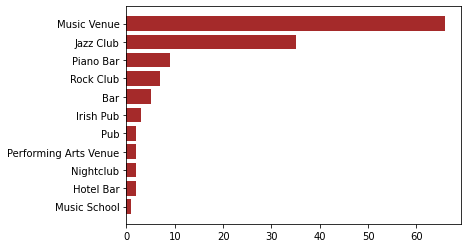

In [39]:
#Display the results with a bar chart
plt.barh(count_venue_categories['Venue Category'],
         count_venue_categories['Count'],
         color='brown',
         align='center')

## Explore and cluster neighborhoods <a id="explore_cluster"></a>

### Explore neighborhoods <a id="exp_n"></a>

Let's create a function that explore a zone (we have to specify latitude and longitude values), in a 500m radius.

In [233]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&time={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            any,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Quartier Name', 
                  'Quartier Latitude', 
                  'Quartier Longitude', 
                  'Venue', 
                  'Venue Category',
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

In [234]:
paris_venues = getNearbyVenues(names=df['Quartier Name'],
                               latitudes=df['Latitude'],
                               longitudes=df['Longitude'])

Saint-Germain-l'Auxerrois
Les Halles
Palais-Royal
Place-Vendôme
Gaillon
Vivienne
Mail
Bonne-Nouvelle
Arts-et-Métiers
Enfants-Rouges
Archives
Sainte-Avoye
Saint-Merri
Saint-Gervais
Arsenal
Notre-Dame
Quartier Saint-Victor
Jardin-des-Plantes
Val-de-Grâce
Sorbonne
Monnaie
Odéon
Notre-Dame-des-Champs
Saint-Germain-des-Prés
Saint-Thomas-d'Aquin
Les Invalides
École-Militaire
Gros-Caillou
Champs-Élysées
Faubourg-du-Roule
La Madeleine
Europe
Saint-Georges
Chaussée-d'Antin
Faubourg-Montmartre
Rochechouart
Saint-Vincent-de-Paul
Porte-Saint-Denis
Porte-Saint-Martin
Hôpital-Saint-Louis
Folie-Méricourt
Saint-Ambroise
La Roquette
Sainte-Marguerite
Bel-Air
Picpus
Bercy
Quinze-Vingts
Salpêtrière
La Gare
Maison-Blanche
Croulebarbe
Montparnasse
Parc Montsouris
Petit-Montrouge
Plaisance
Saint-Lambert
Necker
Grenelle
Javel
Auteuil
La Muette
Porte-Dauphine
Chaillot
Les Ternes
Plaine Monceau
Batignolles
Épinettes
Grandes-Carrières
Clignancourt
Goutte-d'Or
La Chapelle
La Villette
Pont-de-Flandre
Amérique
Com

Let's display our results :

In [42]:
paris_venues.head(5)

,Quartier Name,Quartier Latitude,Quartier Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude
0,Saint-Germain-l'Auxerrois,48.860211,2.336299,Cour Carrée du Louvre,Pedestrian Plaza,48.860360,2.338543
1,Saint-Germain-l'Auxerrois,48.860211,2.336299,Musée du Louvre,Art Museum,48.860847,2.336440
2,Saint-Germain-l'Auxerrois,48.860211,2.336299,La Vénus de Milo (Vénus de Milo),Exhibit,48.859943,2.337234
3,Saint-Germain-l'Auxerrois,48.860211,2.336299,Cour Napoléon,Plaza,48.861172,2.335088
4,Saint-Germain-l'Auxerrois,48.860211,2.336299,Pont des Arts,Bridge,48.858565,2.337635


### Data preparation <a id="data_prep"></a>

We use hot encoding in order to compare neighborhoods together :

In [235]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Quartier Name'] = paris_venues['Quartier Name'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,Quartier Name,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Saint-Germain-l'Auxerrois,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Saint-Germain-l'Auxerrois,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Saint-Germain-l'Auxerrois,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Saint-Germain-l'Auxerrois,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Saint-Germain-l'Auxerrois,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [236]:
# Group the results by Quartier and compute the average on each values
paris_grouped = paris_onehot.groupby('Quartier Name').mean().reset_index()

We write a function to sort the venues in descending order.

In [250]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 15 venues for each neighborhood.

In [251]:
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Quartier Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
quartier_venues_sorted = pd.DataFrame(columns=columns)
quartier_venues_sorted['Quartier Name'] = paris_grouped['Quartier Name']

for ind in np.arange(paris_grouped.shape[0]):
    quartier_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

quartier_venues_sorted.head()

,Quartier Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Amérique,French Restaurant,Metro Station,Pizza Place,Supermarket,Bistro,Café,Bed & Breakfast,Theater,Arts & Entertainment,Park,Pool,Plaza,Deli / Bodega,English Restaurant,Food & Drink Shop
1,Archives,French Restaurant,Burger Joint,Clothing Store,Coffee Shop,Bookstore,Hotel,Bistro,Japanese Restaurant,Plaza,Cocktail Bar,Italian Restaurant,Restaurant,Art Gallery,Sandwich Place,Tea Room
2,Arsenal,French Restaurant,Hotel,Tapas Restaurant,Plaza,Park,Italian Restaurant,Seafood Restaurant,Cocktail Bar,Thai Restaurant,Gastropub,Vegetarian / Vegan Restaurant,Pedestrian Plaza,Boat or Ferry,Tea Room,Museum
3,Arts-et-Métiers,French Restaurant,Hotel,Cocktail Bar,Bar,Restaurant,Chinese Restaurant,Coffee Shop,Wine Bar,Vietnamese Restaurant,Bakery,Art Gallery,Italian Restaurant,Japanese Restaurant,Boutique,Steakhouse
4,Auteuil,French Restaurant,Italian Restaurant,Supermarket,Café,Hotel,Japanese Restaurant,Asian Restaurant,Bakery,Pizza Place,Bistro,Bike Rental / Bike Share,Market,Office,Garden,Middle Eastern Restaurant


### Neighborhoods Clustering <a id="clustering"></a>

We use a machine learning alogorithm in order to cluster the different quartiers, to then identify where to open our new Jazz Club.

To do so, we can use K-means algorithm. 

The first step is to choose K value, ie the number of clusters. To do so, we can apply the « elbow method ». We start by running the algorithm for different K values ranging from 1 to 10 and report the mean distance of data points to cluster centroids. 

In [252]:
#run k-means and retrieve the mean distance of datapoints to cluster centroids
def cluster_quartier(kclusters, grouped):
    grouped_clustering = grouped.drop('Quartier Name', 1)
    
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)
    
    return kmeans.inertia_

Text(0, 0.5, 'mean distance of data points to cluster centroid')

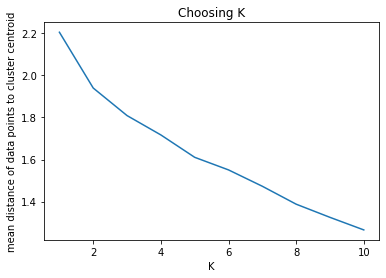

In [253]:
#Apply K-Means for several values of K
avg_distance=[]
K = 10
for k in range(1,K+1):
    inertia = cluster_quartier(k, paris_grouped)
    avg_distance.append(inertia)

plt.plot(range(1,K+1),avg_distance)
plt.title('Choosing K')
plt.xlabel('K')
plt.ylabel('mean distance of data points to cluster centroid')

As we can see, the « elbow » is quite hard to identify… 

Our empirical studies showed that K=4 seems to be a pretty good tradeoff.

In [254]:
# set number of clusters
kclusters = 4

paris_grouped_clustering = paris_grouped.drop('Quartier Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 1, 3, 1, 3, 3, 3, 0, 3], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 15 venues for each neighborhood.

In [255]:
# add clustering labels
quartier_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
quartier_venues_sorted

#Add Quartier Latitude and Longitude to place it on the map later on
paris_merged = df[['Latitude','Longitude', 'Quartier Name']]

# merge dataframes to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(quartier_venues_sorted.set_index('Quartier Name'), on='Quartier Name')

In [257]:
paris_merged.head(10)

,Latitude,Longitude,Quartier Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,48.860211,2.336299,Saint-Germain-l'Auxerrois,0,French Restaurant,Hotel,Plaza,Coffee Shop,Café,Historic Site,Art Museum,Exhibit,Clothing Store,Bar,Cosmetics Shop,Bookstore,Garden,Bistro,Furniture / Home Store
1,48.862466,2.346009,Les Halles,3,French Restaurant,Bakery,Wine Bar,Hotel,Italian Restaurant,Pizza Place,Cocktail Bar,Clothing Store,Chinese Restaurant,Restaurant,Café,Ice Cream Shop,Pedestrian Plaza,Breakfast Spot,Spa
2,48.863585,2.336204,Palais-Royal,0,Japanese Restaurant,French Restaurant,Plaza,Hotel,Café,Coffee Shop,Art Museum,Italian Restaurant,Historic Site,Ramen Restaurant,Bar,Korean Restaurant,Theater,Bakery,Bistro
3,48.867463,2.329428,Place-Vendôme,0,Hotel,Japanese Restaurant,French Restaurant,Sandwich Place,Jewelry Store,Dessert Shop,Plaza,Boutique,Chocolate Shop,Pastry Shop,Bookstore,Cocktail Bar,Candy Store,Bakery,Gourmet Shop
4,48.869135,2.332909,Gaillon,0,Japanese Restaurant,Hotel,French Restaurant,Chocolate Shop,Korean Restaurant,Jewelry Store,Coffee Shop,Sandwich Place,Wine Bar,Concert Hall,Plaza,Pastry Shop,Italian Restaurant,Bakery,Gourmet Shop
5,48.868859,2.339363,Vivienne,0,French Restaurant,Japanese Restaurant,Bistro,Hotel,Italian Restaurant,Salad Place,Bookstore,Coffee Shop,Food & Drink Shop,Bakery,Udon Restaurant,Café,Gym,Wine Bar,Korean Restaurant
6,48.868054,2.344593,Mail,3,Cocktail Bar,French Restaurant,Bakery,Wine Bar,Bar,Italian Restaurant,Salad Place,Thai Restaurant,Coffee Shop,Restaurant,Indie Movie Theater,Pizza Place,Hotel,Pedestrian Plaza,Bistro
7,48.870623,2.348750,Bonne-Nouvelle,3,French Restaurant,Hotel,Bar,Wine Bar,Cocktail Bar,Thai Restaurant,Pizza Place,Coffee Shop,Restaurant,Korean Restaurant,Beer Bar,Mexican Restaurant,Bakery,Greek Restaurant,Sandwich Place
8,48.865441,2.356132,Arts-et-Métiers,3,French Restaurant,Hotel,Cocktail Bar,Bar,Restaurant,Chinese Restaurant,Coffee Shop,Wine Bar,Vietnamese Restaurant,Bakery,Art Gallery,Italian Restaurant,Japanese Restaurant,Boutique,Steakhouse
9,48.864332,2.362611,Enfants-Rouges,3,French Restaurant,Wine Bar,Japanese Restaurant,Hotel,Burger Joint,Restaurant,Cocktail Bar,Art Gallery,Sandwich Place,Bakery,Café,Bistro,Italian Restaurant,Vietnamese Restaurant,Creperie


Let's display the results on the map :

In [258]:
map_clusters = folium.Map(location=[paris_latitude, paris_longitude], 
                          zoom_start=12, 
                          tiles='Stamen Toner')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, quartier, cluster in zip(paris_merged['Latitude'], 
                                       paris_merged['Longitude'], 
                                       paris_merged['Quartier Name'], 
                                       paris_merged['Cluster Labels']):
    label = folium.Popup(str(quartier) + '\n' 
                         + '(Cluster {})'.format(str(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster Analysis <a id="cluster_analysis"></a>

We create a function to analyze a particular cluster :

In [259]:
def analyze_cluster(cluster_label, nb_top_categories):
    
    #Retrieve quartier name + most common venues
    cluster_to_analyze = paris_merged.loc[
        paris_merged['Cluster Labels'] == cluster_label,
        paris_merged.columns[[2] + list(range(4, paris_merged.shape[1]))]
    ]
    
    #Retrieve cluster's most important categories
    #append all the venues in a list
    val=[]
    for index, item in cluster_to_analyze.iloc[:,list(range(1, cluster_to_analyze.shape[1]))].iteritems():
        val.append(cluster_to_analyze[index].values)
    # Flatten the list
    flat_list = []
    for sublist in val:
        for item in sublist:
            flat_list.append(item)

    # Create a panda DataFrame from list
    top_venue_list = pd.DataFrame(flat_list)
    top_venue_list.rename(columns={0:'ratio'}, inplace=True)

    # Print the percentage of each categories
    cluster_main_categories = top_venue_list['ratio'].value_counts().head(nb_top_categories)*100/top_venue_list.shape[0]
    
    # transform to a dataframe
    cluster_main_categories_top = pd.DataFrame(cluster_main_categories)
    
    cluster_main_categories_top.reset_index(inplace=True)
    cluster_main_categories_top.rename(columns={'index': 'Cluster{} '.format(str(cluster_label))+'top10'}, inplace=True)    
    
    return cluster_to_analyze, cluster_main_categories_top

In [260]:
nb_top_categories = 20

#### Cluster 0

In [261]:
cluster0, cluster0_main_cat = analyze_cluster(0,nb_top_categories)

In [263]:
cluster0.head(5)

,Quartier Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Saint-Germain-l'Auxerrois,French Restaurant,Hotel,Plaza,Coffee Shop,Café,Historic Site,Art Museum,Exhibit,Clothing Store,Bar,Cosmetics Shop,Bookstore,Garden,Bistro,Furniture / Home Store
2,Palais-Royal,Japanese Restaurant,French Restaurant,Plaza,Hotel,Café,Coffee Shop,Art Museum,Italian Restaurant,Historic Site,Ramen Restaurant,Bar,Korean Restaurant,Theater,Bakery,Bistro
3,Place-Vendôme,Hotel,Japanese Restaurant,French Restaurant,Sandwich Place,Jewelry Store,Dessert Shop,Plaza,Boutique,Chocolate Shop,Pastry Shop,Bookstore,Cocktail Bar,Candy Store,Bakery,Gourmet Shop
4,Gaillon,Japanese Restaurant,Hotel,French Restaurant,Chocolate Shop,Korean Restaurant,Jewelry Store,Coffee Shop,Sandwich Place,Wine Bar,Concert Hall,Plaza,Pastry Shop,Italian Restaurant,Bakery,Gourmet Shop
5,Vivienne,French Restaurant,Japanese Restaurant,Bistro,Hotel,Italian Restaurant,Salad Place,Bookstore,Coffee Shop,Food & Drink Shop,Bakery,Udon Restaurant,Café,Gym,Wine Bar,Korean Restaurant


In [264]:
cluster0_main_cat.head(5)

,Cluster0 top10,ratio
0,Hotel,6.666667
1,French Restaurant,6.666667
2,Japanese Restaurant,5.416667
3,Café,4.583333
4,Bakery,4.166667


#### Cluster 1

In [58]:
cluster1, cluster1_main_cat = analyze_cluster(1,nb_top_categories)

#### Cluster 2

In [59]:
cluster2, cluster2_main_cat = analyze_cluster(2,nb_top_categories)

#### Cluster 3

In [60]:
cluster3, cluster3_main_cat = analyze_cluster(3,nb_top_categories)

#### Sumary of cluster analysis

In [265]:
columns=['0','1']
#,'cluster2','cluster3','cluster4','cluster5','cluster6']

top10_by_cluster = pd.concat([cluster0_main_cat.iloc[:,0],
                              cluster1_main_cat.iloc[:,0],
                              cluster2_main_cat.iloc[:,0],
                              cluster3_main_cat.iloc[:,0]]
                             ,axis=1)

top10_by_cluster

,Cluster0 top10,Cluster1 top10,Cluster2 top10,Cluster3 top10
0,Hotel,French Restaurant,French Restaurant,French Restaurant
1,French Restaurant,Hotel,Hotel,Hotel
2,Japanese Restaurant,Café,Italian Restaurant,Bakery
3,Café,Bakery,Bakery,Italian Restaurant
4,Bakery,Japanese Restaurant,Bar,Bistro
5,Italian Restaurant,Italian Restaurant,Bistro,Café
6,Coffee Shop,Bistro,Japanese Restaurant,Japanese Restaurant
7,Sandwich Place,Bar,Coffee Shop,Restaurant
8,Plaza,Coffee Shop,Pizza Place,Coffee Shop
9,Bistro,Cocktail Bar,Burger Joint,Sandwich Place


### Superposition of clusters and number of music venues <a id="superposition"></a>

In [267]:
my_map = folium.Map(location=[paris_latitude, paris_longitude],
                    zoom_start=12, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=paris_quartier_geo,
    data=paris_music_venues_grouped_quartier,
    columns=["INSEE_ID", 'Music Venue Count'],
    key_on='feature.properties.c_quinsee',
    fill_color='GnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of music venues in a 500m radius').add_to(my_map)

markers_colors = []
for lat, lon, quartier, cluster in zip(paris_merged['Latitude'], 
                                       paris_merged['Longitude'], 
                                       paris_merged['Quartier Name'], 
                                       paris_merged['Cluster Labels']):
    label = folium.Popup(str(quartier) + '\n' 
                         + '(Cluster {})'.format(str(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(my_map)
    
my_map

## A new Jazz Club in Paris <a id="new_jazz_club"></a>

Let's create a function that retrieve all the Jazz Clubs in Paris :

In [268]:
jazz_club_ID = '4bf58dd8d48988d1e7931735'

def getNearbyJazzClubs(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            jazz_club_ID,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request        
        results = requests.get(url).json()['response']['venues']        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['categories'][0]['name'],
            v['location']['lat'], 
            v['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Quartier Name', 
                  'Quartier Latitude', 
                  'Quartier Longitude', 
                  'Venue', 
                  'Venue Category',
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

In [269]:
jazz_venues = getNearbyJazzClubs(names=df['Quartier Name'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Saint-Germain-l'Auxerrois
Les Halles
Palais-Royal
Place-Vendôme
Gaillon
Vivienne
Mail
Bonne-Nouvelle
Arts-et-Métiers
Enfants-Rouges
Archives
Sainte-Avoye
Saint-Merri
Saint-Gervais
Arsenal
Notre-Dame
Quartier Saint-Victor
Jardin-des-Plantes
Val-de-Grâce
Sorbonne
Monnaie
Odéon
Notre-Dame-des-Champs
Saint-Germain-des-Prés
Saint-Thomas-d'Aquin
Les Invalides
École-Militaire
Gros-Caillou
Champs-Élysées
Faubourg-du-Roule
La Madeleine
Europe
Saint-Georges
Chaussée-d'Antin
Faubourg-Montmartre
Rochechouart
Saint-Vincent-de-Paul
Porte-Saint-Denis
Porte-Saint-Martin
Hôpital-Saint-Louis
Folie-Méricourt
Saint-Ambroise
La Roquette
Sainte-Marguerite
Bel-Air
Picpus
Bercy
Quinze-Vingts
Salpêtrière
La Gare
Maison-Blanche
Croulebarbe
Montparnasse
Parc Montsouris
Petit-Montrouge
Plaisance
Saint-Lambert
Necker
Grenelle
Javel
Auteuil
La Muette
Porte-Dauphine
Chaillot
Les Ternes
Plaine Monceau
Batignolles
Épinettes
Grandes-Carrières
Clignancourt
Goutte-d'Or
La Chapelle
La Villette
Pont-de-Flandre
Amérique
Com

Let's display the results

In [271]:
jazz_venues.head(10)

,Quartier Name,Quartier Latitude,Quartier Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude
0,Saint-Germain-l'Auxerrois,48.860211,2.336299,Chez Papa Jazz Club,Jazz Club,48.855377,2.333497
1,Saint-Germain-l'Auxerrois,48.860211,2.336299,Jazz Club,Jazz Club,48.855308,2.333580
2,Saint-Germain-l'Auxerrois,48.860211,2.336299,Q&R,Jazz Club,48.863772,2.332568
3,Saint-Germain-l'Auxerrois,48.860211,2.336299,Osprey Paris,Jewelry Store,48.864537,2.333134
4,Les Halles,48.862466,2.346009,Histoire d'Or,Jazz Club,48.862384,2.346579
5,Les Halles,48.862466,2.346009,Sunset,Jazz Club,48.859821,2.347729
6,Les Halles,48.862466,2.346009,Sunset/Sunside,Music Venue,48.859787,2.347769
7,Les Halles,48.862466,2.346009,Baiser Salé,Jazz Club,48.859785,2.347842
8,Les Halles,48.862466,2.346009,Jammin Club,Jazz Club,48.860061,2.350649
9,Les Halles,48.862466,2.346009,Duc des Lombards,Jazz Club,48.859672,2.348608


Let's display on the map all the data gathered so far :

In [280]:
my_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=paris_quartier_geo,
    data=paris_music_venues_grouped_quartier,
    columns=["INSEE_ID", 'Music Venue Count'],
    key_on='feature.properties.c_quinsee',
    fill_color='GnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of music venues in a 500m radius').add_to(my_map)

# add cluster labels onto the map
markers_colors = []
for lat, lon, quartier, cluster in zip(paris_merged['Latitude'], 
                                       paris_merged['Longitude'], 
                                       paris_merged['Quartier Name'], 
                                       paris_merged['Cluster Labels']):
    label = folium.Popup(str(quartier) + '\n' 
                         + '(Cluster {})'.format(str(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(my_map)
    
# loop through the jazz_venues and add each to the map
for lat, lng, venue, venue_category in zip(jazz_venues['Venue Latitude'], 
                                           jazz_venues['Venue Longitude'], 
                                           jazz_venues['Venue'], 
                                           jazz_venues['Venue Category']):
    folium.CircleMarker(
        [lat, lng],
        radius=3, 
        color='yellow',
        fill=True,
        popup=(venue+'\n'+'({})'.format(venue_category)),
        fill_color='yellow',
        fill_opacity=0.6
    ).add_to(my_map)


#Allow to create a legend onto the map
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#ff0000;opacity:0.7;'></span>cluster 0</li>
    <li><span style='background:#8000ff;opacity:0.7;'></span>cluster 1</li>
    <li><span style='background:#2adddd;opacity:0.7;'></span>cluster 2</li>
    <li><span style='background:#d4dd80;opacity:0.7;'></span>cluster 3</li>
    <li><span style='background:yellow;opacity:0.7;'></span>Jazz clubs</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 16px;
    margin-right: 5px;
    margin-left: 0;
    border-radius: 50%;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)
my_map.get_root().add_child(macro)

my_map

## Conclusion and Results <a id="conclusion_results"></a>

Cluster 1 and 2 seem to be the most promising to help us identify where to open our Jazz Club.

In [283]:
#Group high potential clusters cluster 1 and 2
df_jazz_clusters = cluster1[['Quartier Name']]
df_jazz_clusters = df_jazz_clusters.append(cluster2[['Quartier Name']],ignore_index=True)

#Count the number of jazz venues per quartier
jazz_venues_per_quartier = jazz_venues[['Quartier Name','Venue']].groupby('Quartier Name').count()
jazz_venues_per_quartier.reset_index(inplace=True)

df_jazz_clusters

,Quartier Name
0,Saint-Germain-l'Auxerrois
1,Palais-Royal
2,Place-Vendôme
3,Gaillon
4,Vivienne
...,...
60,Grandes-Carrières
61,Clignancourt
62,Combat
63,Belleville


We first count the number of Jazz venues in the promising clusters and then normalize the value. 

We also slightly change the normalized values :

**xnew = 1 - xold/xmax**

This way, we penalize quartiers which already have a lot of Jazz Clubs. 

In [284]:
df_jazz_high_pot = df_jazz_clusters.merge(jazz_venues_per_quartier,how='left')
df_jazz_high_pot.rename(columns={'Venue': 'Count of Jazz Venue'},inplace=True)
df_jazz_high_pot.fillna(0,inplace=True)

#find frequency of venues xnew = 1 - xold/xmax (1- parce qu'on pense que moins il y a de clubs, mieux c'est)
df_jazz_high_pot['1 - normalized count'] = 1 - df_jazz_high_pot['Count of Jazz Venue']/df_jazz_high_pot['Count of Jazz Venue'].max()

df_jazz_high_pot.head(10)

,Quartier Name,Count of Jazz Venue,1 - normalized count
0,Saint-Germain-l'Auxerrois,4.0,0.500
1,Palais-Royal,2.0,0.750
2,Place-Vendôme,2.0,0.750
3,Gaillon,1.0,0.875
4,Vivienne,0.0,1.000
5,Mail,1.0,0.875
6,Bonne-Nouvelle,1.0,0.875
7,Arts-et-Métiers,1.0,0.875
8,Enfants-Rouges,2.0,0.750
9,Archives,2.0,0.750


We then merge this data frame with Music Venue Count and INSEE_ID. This latest will help us display our data on the map. 

We also normalize Music Venue Count.

In [285]:
df_jazz_high_pot = df_jazz_high_pot.merge(paris_music_venues_grouped_quartier,
                                          left_on='Quartier Name',
                                          right_on='Quartier Name_y')

df_jazz_high_pot.drop('Quartier Name_y',1,inplace=True)
df_jazz_high_pot[['Music Venue Count']]=df_jazz_high_pot[['Music Venue Count']]/df_jazz_high_pot[['Music Venue Count']].max()

df_jazz_high_pot.head(10)

,Quartier Name,Count of Jazz Venue,1 - normalized count,Music Venue Count,INSEE_ID
0,Saint-Germain-l'Auxerrois,4.0,0.500,0.588235,7510101
1,Palais-Royal,2.0,0.750,0.294118,7510103
2,Place-Vendôme,2.0,0.750,0.529412,7510104
3,Gaillon,1.0,0.875,0.470588,7510201
4,Vivienne,0.0,1.000,0.529412,7510202
5,Mail,1.0,0.875,0.647059,7510203
6,Bonne-Nouvelle,1.0,0.875,1.000000,7510204
7,Arts-et-Métiers,1.0,0.875,0.294118,7510301
8,Enfants-Rouges,2.0,0.750,0.470588,7510302
9,Archives,2.0,0.750,0.294118,7510303


We now compute a new metric called 'rating' and representing the 'potential' of each quartier to welcome our new Jazz Club. 'rating' is defined as follows : 

**Rating = (1-normalized count) x Music Venue Count**

In [286]:
df_jazz_high_pot["rating"] = df_jazz_high_pot['1 - normalized count']*df_jazz_high_pot['Music Venue Count']
df_jazz_high_pot.head(10)

,Quartier Name,Count of Jazz Venue,1 - normalized count,Music Venue Count,INSEE_ID,rating
0,Saint-Germain-l'Auxerrois,4.0,0.500,0.588235,7510101,0.294118
1,Palais-Royal,2.0,0.750,0.294118,7510103,0.220588
2,Place-Vendôme,2.0,0.750,0.529412,7510104,0.397059
3,Gaillon,1.0,0.875,0.470588,7510201,0.411765
4,Vivienne,0.0,1.000,0.529412,7510202,0.529412
5,Mail,1.0,0.875,0.647059,7510203,0.566176
6,Bonne-Nouvelle,1.0,0.875,1.000000,7510204,0.875000
7,Arts-et-Métiers,1.0,0.875,0.294118,7510301,0.257353
8,Enfants-Rouges,2.0,0.750,0.470588,7510302,0.352941
9,Archives,2.0,0.750,0.294118,7510303,0.220588


We can now display "rating" information, and identify the most promising quariter to welcome our new Jazz club :

In [287]:
my_map = folium.Map(location=[paris_latitude, paris_longitude], 
                    zoom_start=12, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=paris_quartier_geo,
    data=df_jazz_high_pot,
    columns=["INSEE_ID", 'rating'],
    key_on='feature.properties.c_quinsee',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Potential for a new Jazz Club').add_to(my_map)

my_map

In [288]:
highest_pot = df_jazz_high_pot[['Quartier Name', 'rating']].sort_values('rating', ascending=False).reset_index(drop=True)
highest_pot.head(15)

,Quartier Name,rating
0,Bonne-Nouvelle,0.875000
1,Folie-Méricourt,0.772059
2,Mail,0.566176
3,Faubourg-Montmartre,0.566176
4,Porte-Saint-Denis,0.566176
5,Vivienne,0.529412
6,Saint-Georges,0.514706
7,Porte-Saint-Martin,0.441176
8,Charonne,0.411765
9,Gaillon,0.411765


*by François MORENNE - IBM Data Science - Capstone Project*